In [109]:
%load_ext autoreload
%autoreload 2

from video_night import *
cache = np.load("results/Results_night/cache.npz", allow_pickle = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


                              reference_image_origin  \
0  ../robotcar_dataset/overcast-reference/rear/14...   

                                  query_image_origin  num_initial_matches  \
0  ../robotcar_dataset/night/rear/141823531480042...                  505   

   num_final_matches  initial_cost  final_cost  \
0                101      0.621332    0.145905   

                               track_pickle_path  
0  results/subset/convergence_fp/query_0_track.p  
{12: 'results/subset/convergence_fp/query0_hc12.png', 34: 'results/subset/convergence_fp/query0_hc34.png', 76: 'results/subset/convergence_fp/query0_hc76.png', 73: 'results/subset/convergence_fp/query0_hc73.png', 66: 'results/subset/convergence_fp/query0_hc66.png', 51: 'results/subset/convergence_fp/query0_hc51.png', 82: 'results/subset/convergence_fp/query0_hc82.png'}
{12: 'results/subset/convergence_fp/query0_hc12.png', 34: 'results/subset/convergence_fp/query0_hc34.png', 76: 'results/subset/convergence_fp/query0_hc76.png

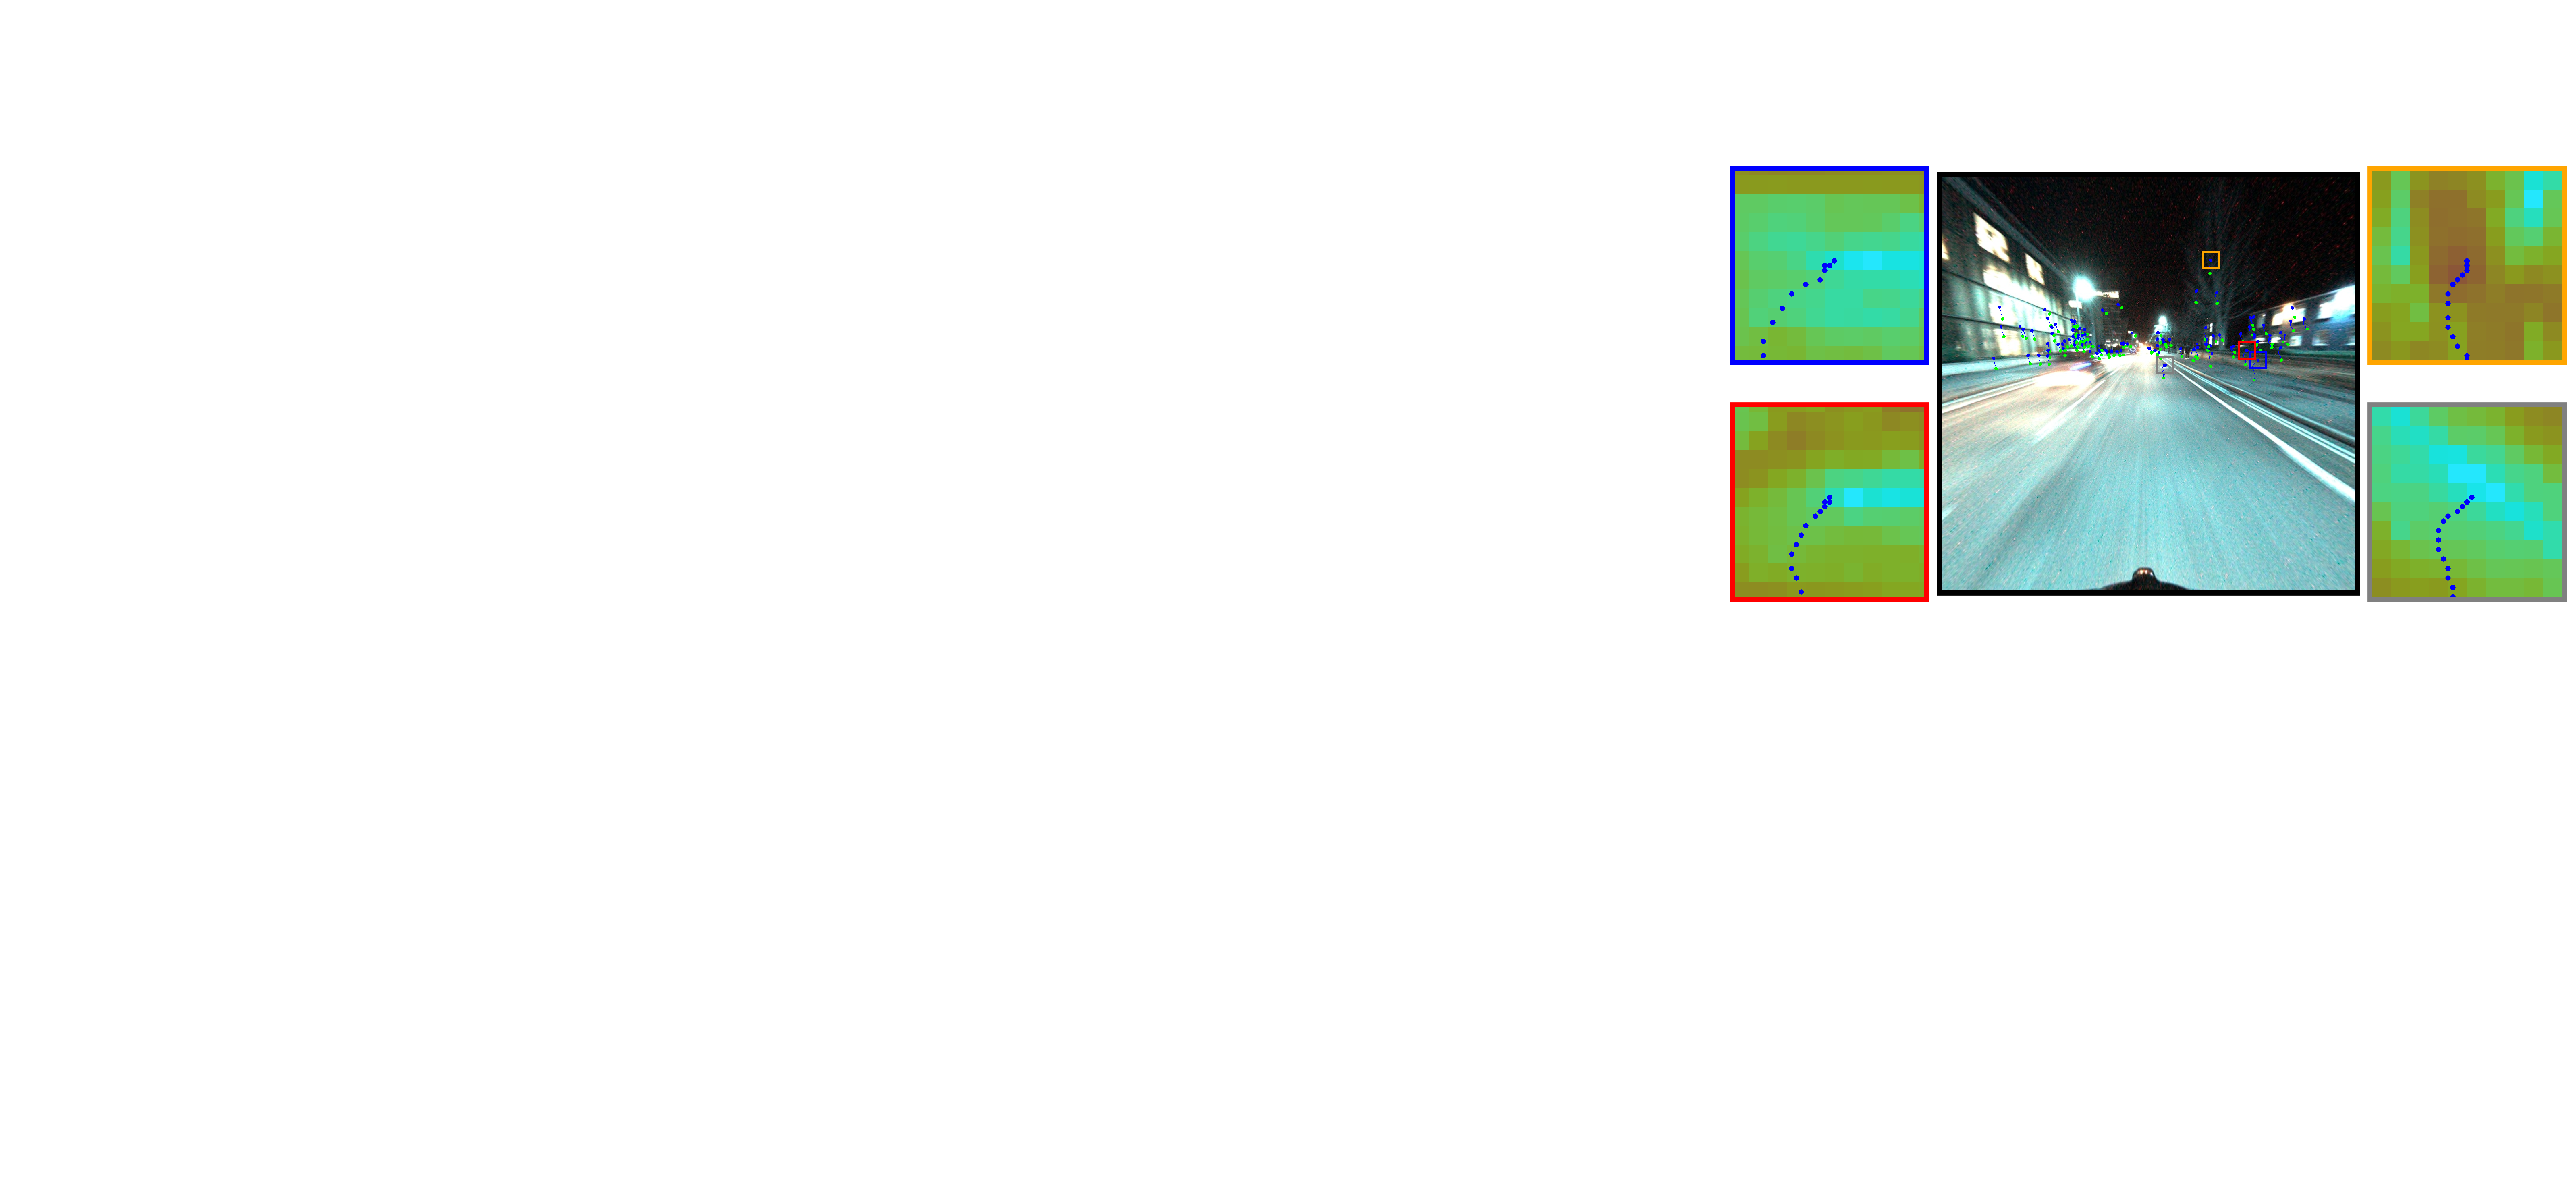

In [142]:
df = pd.read_csv("results/subset/convergence_fp/summary.csv",sep=";")
print(df)
idx = 0#35
row = df.iloc[idx]
img = cv2.imread(row.query_image_origin)#cv2.cvtColor(cv2.imread(row.reference_image_origin), cv2.COLOR_BGR2RGB)
track = pickle.load(open(row["track_pickle_path"], "rb"))
#print(track.keys())
hc_dict=track["hc_dict"]
print(hc_dict)
hc_image_dict={}
k=0

print(hc_dict)
for key in hc_dict:
    hc_image_dict[key] = cv2.imread(hc_dict[key])
    k+=1
    if k==4:
        break
print(track["points2d"][0][list(hc_image_dict.keys())])
save_hc_video("final_render"+str(idx)+".mp4", img, hc_image_dict, 50, track)



In [99]:
def update_corr(refax, qax, ref2d, q2d, query_image, match_indices):
    qax.clear()
    qax.axis("off")
    qax.imshow(query_image)
    sns.scatterplot(x=q2d[:,0], y = q2d[:,1], color = "lime", ax = qax, linewidth=0, size = 1)
    
    for index in match_indices:
        con = ConnectionPatch(xyA=q2d[index], xyB=ref2d[index], coordsA="data", coordsB="data",
                      axesA=qax, axesB=refax, color="limegreen")
            
        qax.add_artist(con)
    qax.get_legend().remove()
    
    
    
    

In [102]:
def save_correspondences_video(video_path, ref_image, query_image, ref2d, track, n_iters, pts_3d, K):
    fig, axes = create_corresp_axes()
    height, width, layers = plot_3d.fig2data(fig).shape
    # Left is ref, rightr is query[1]
    ref_ax = axes[0]
    query_ax = axes[1]
    ref_ax.imshow(ref_image)
    query_ax.imshow(query_image)
    i = 0
    qpoints = track["points2d"]
    
    q2d = qpoints[0]
    
    R_list = track["Rs"][:n_iters]
    #cost_list = track["costs"][:n_iters]
    t_list = track["ts"][:n_iters]
    
    sns.scatterplot(x=ref2d[:,0], y = ref2d[:,1], color = "red", size = 1, ax = ref_ax, linewidth=0)
    
    sns.scatterplot(x=q2d[:,0], y = q2d[:,1], color = "lime", size = 1, ax = query_ax, linewidth=0)
    
    query_ax.get_legend().remove()
    ref_ax.get_legend().remove()
    pts_3d = torch.from_numpy( pts_3d.reshape(-1,3) ) 
    video= cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 50, (width,height))
    #print(np.reshape(pts_3d, (-1,3)).shape)
    for i in range(n_iters):
        print(i)
        R = R_list[i]
        t = t_list[i]
        points_3d = torch.mm(R, pts_3d.T).T + t
        query_2d = torch.round(from_homogeneous(torch.mm(K, points_3d.T).T)).type(torch.IntTensor)-1
        update_corr(ref_ax, query_ax, ref2d, query_2d, query_image, [1,30, 90 , 50 ,32, 150, 350, 450, 500])
        video.write(plot_3d.fig2data(fig))
    video.release()
    
    
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


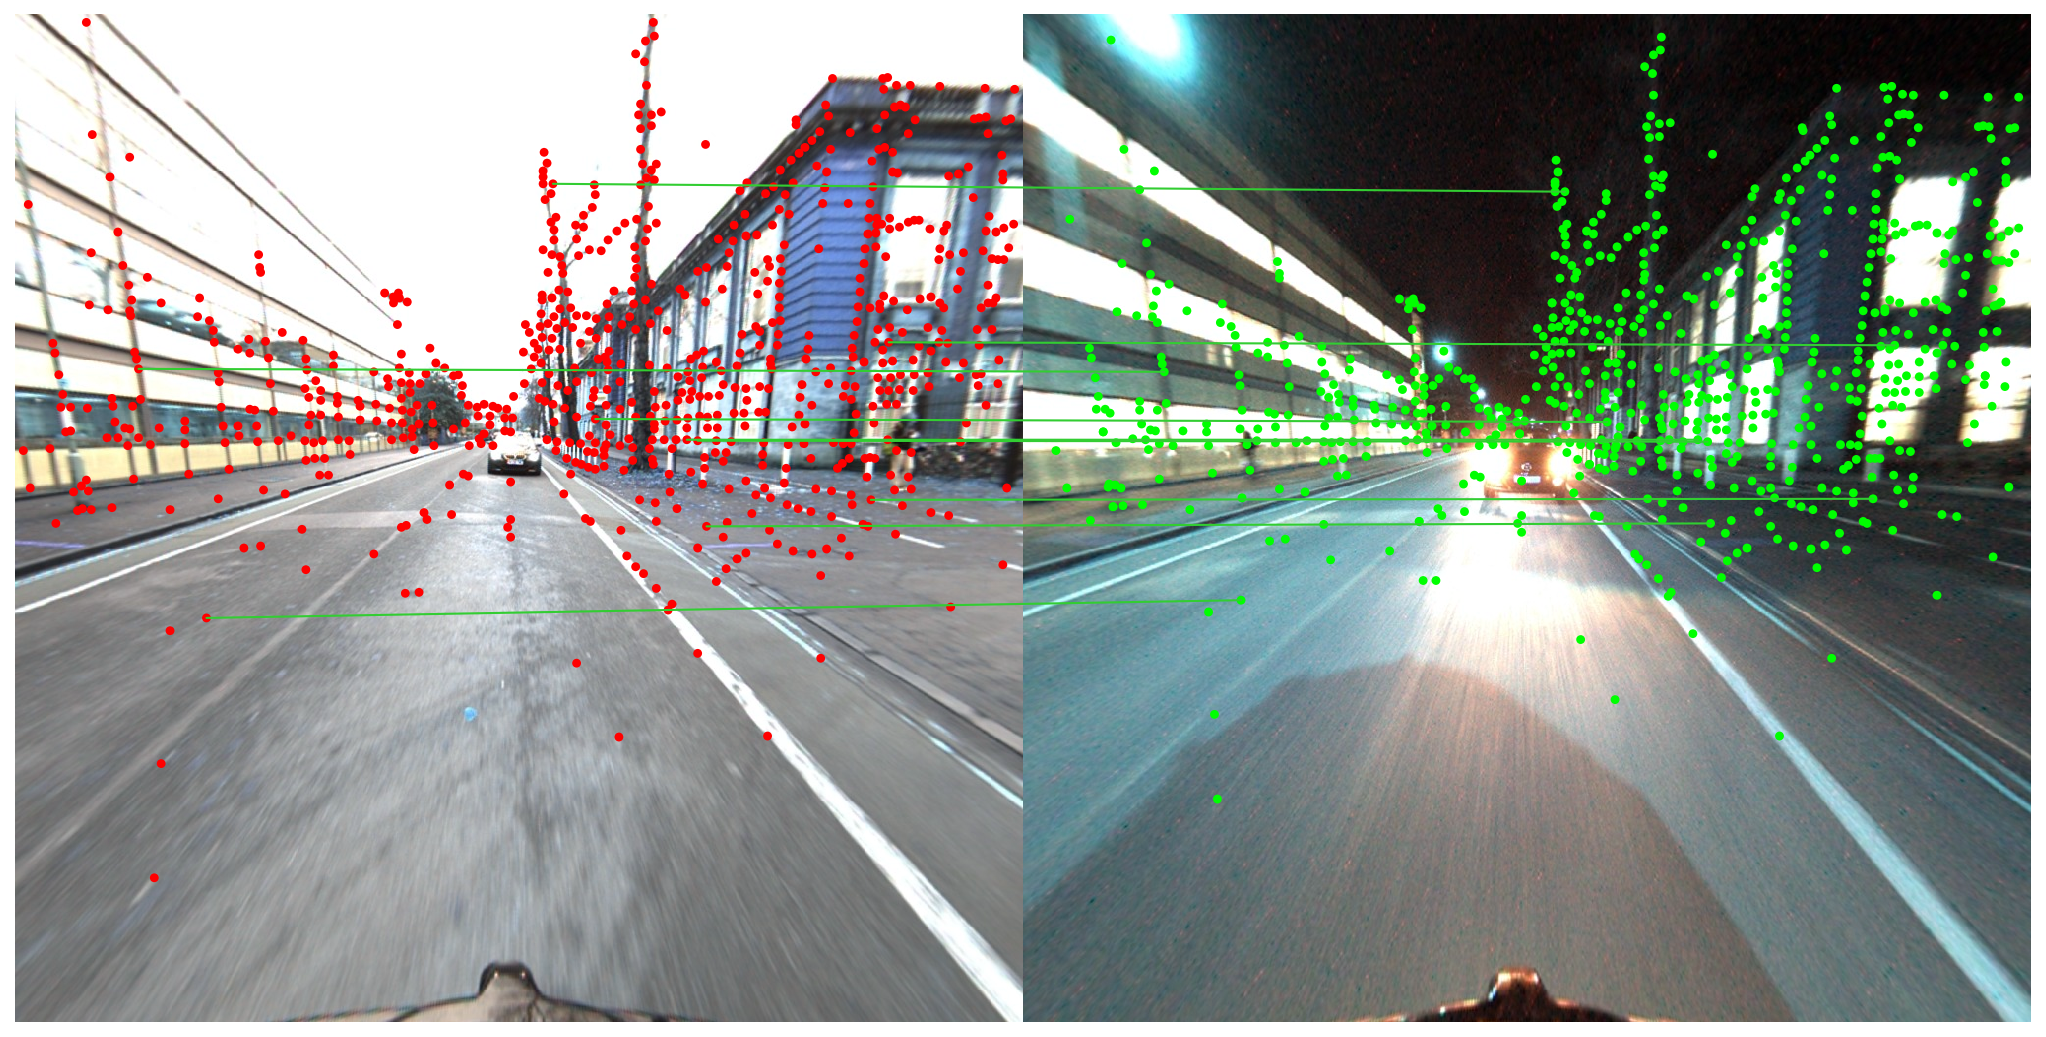

In [104]:
from helpers.utils import (from_homogeneous, to_homogeneous,
                batched_eye_like, skew_symmetric, so3exp_map)
from datasets import dataload_helpers as data_helpers



df = pd.read_csv("rresults/zzfinal/summary.csv",sep=";")
idx = 0#35
row = df.iloc[idx]
a = "/local/home/ntselepidis/3DV/RobotCar-Seasons/images/"+row.query_image_origin.replace("../robotcar_dataset/","")
filename_to_intrinsics = data_helpers.load_intrinsics([row.reference_image_origin, row.query_image_origin])
q_img = cv2.imread(row.query_image_origin)#cv2.cvtColor(cv2.imread(row.reference_image_origin), cv2.COLOR_BGR2RGB)
ref_img = cv2.imread(row.reference_image_origin)
ref_2d = cache[a].item()["reference_2D"]
K = torch.from_numpy(filename_to_intrinsics[row.reference_image_origin][0]).type(torch.DoubleTensor)


track = pickle.load(open(row["track_pickle_path"], "rb"))
hc_dict=track["hc_dict"] #110
save_correspondences_video("ffsmall.mp4", ref_img, q_img, ref_2d, track, 120, cache[a].item()["points_3D"], K)

In [48]:
a = "/local/home/ntselepidis/3DV/RobotCar-Seasons/images/"+row.query_image_origin.replace("../robotcar_dataset/","")

In [ ]:
cache[a]